# Kepler-79

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lightkurve as lk
from glob import glob
import ombre as om
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

In [3]:
name = 'Kepler-79'

In [4]:
fnames = np.asarray(glob(f'/Volumes/Nibelheim/hst/data/{name}/*.fits'))

In [5]:
len(fnames)

184

In [6]:
pixel_mask = np.zeros((256, 256))
pixel_mask[140:190] = 1

In [8]:
obs = om.Observation.from_files(fnames, pixel_mask=pixel_mask, force=True)

Forward:   0%|                                                                         | 0/2 [00:00<?, ?it/s]/Users/ch/HST/projects/ombre/src/ombre/visit.py:226: RuntimeWarning: divide by zero encountered in true_divide
  w[self.err / self.sci > 0.1] = 1e10
Forward:  50%|████████████████████████████████▌                                | 1/2 [00:14<00:14, 14.02s/it]/Users/ch/HST/projects/ombre/src/ombre/visit.py:226: RuntimeWarning: divide by zero encountered in true_divide
  w[self.err / self.sci > 0.1] = 1e10
Backward: 100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.11it/s]


In [9]:
obs

KEPLER-79 [4 planets, 1 Visits]

In [10]:
clc = lk.search_lightcurve(name, mission='Kepler', cadence='long').download_all().stitch().remove_nans()
clc.flux = clc.flux.value * u.electron/u.s
clc.flux_err = clc.flux_err.value * u.electron/u.s

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

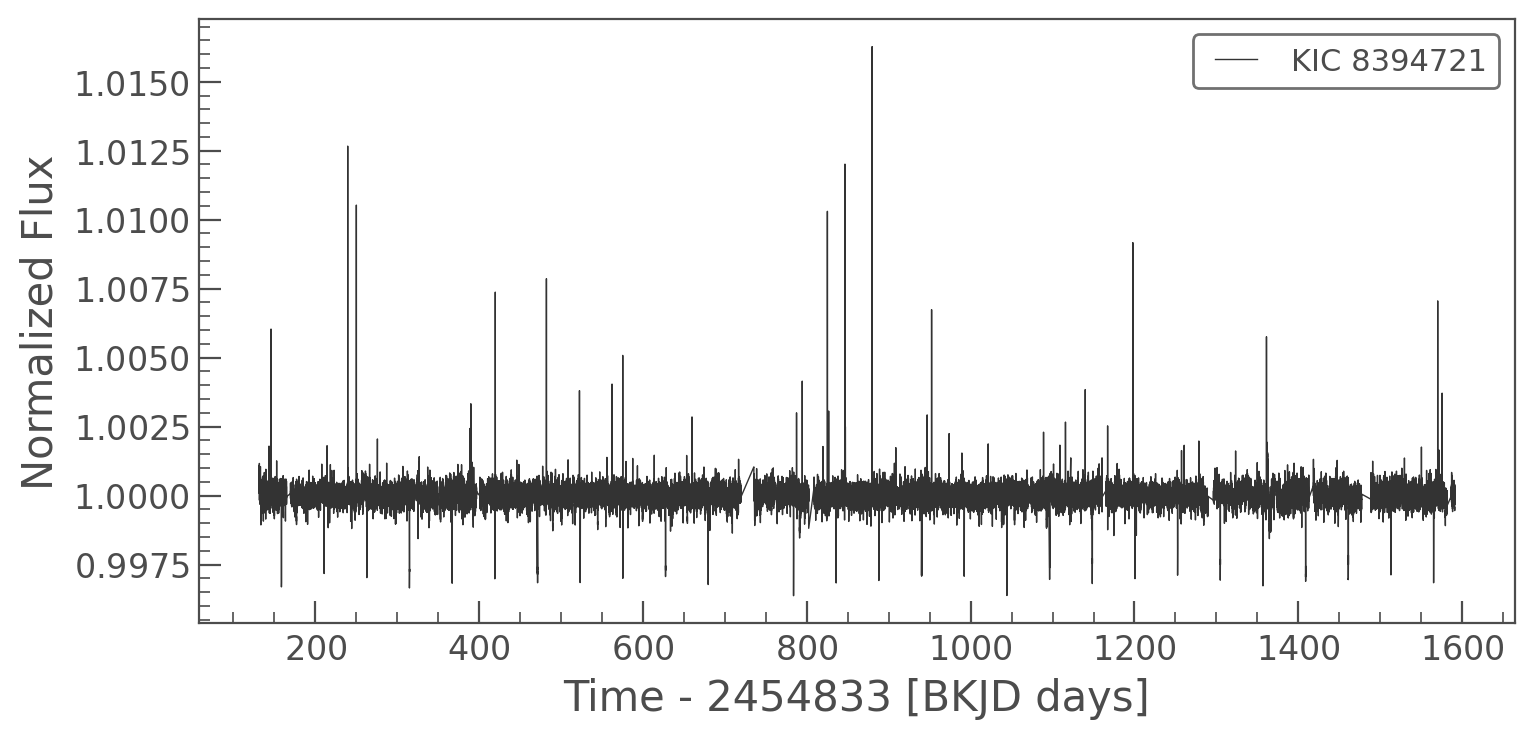

In [11]:
clc.plot()

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

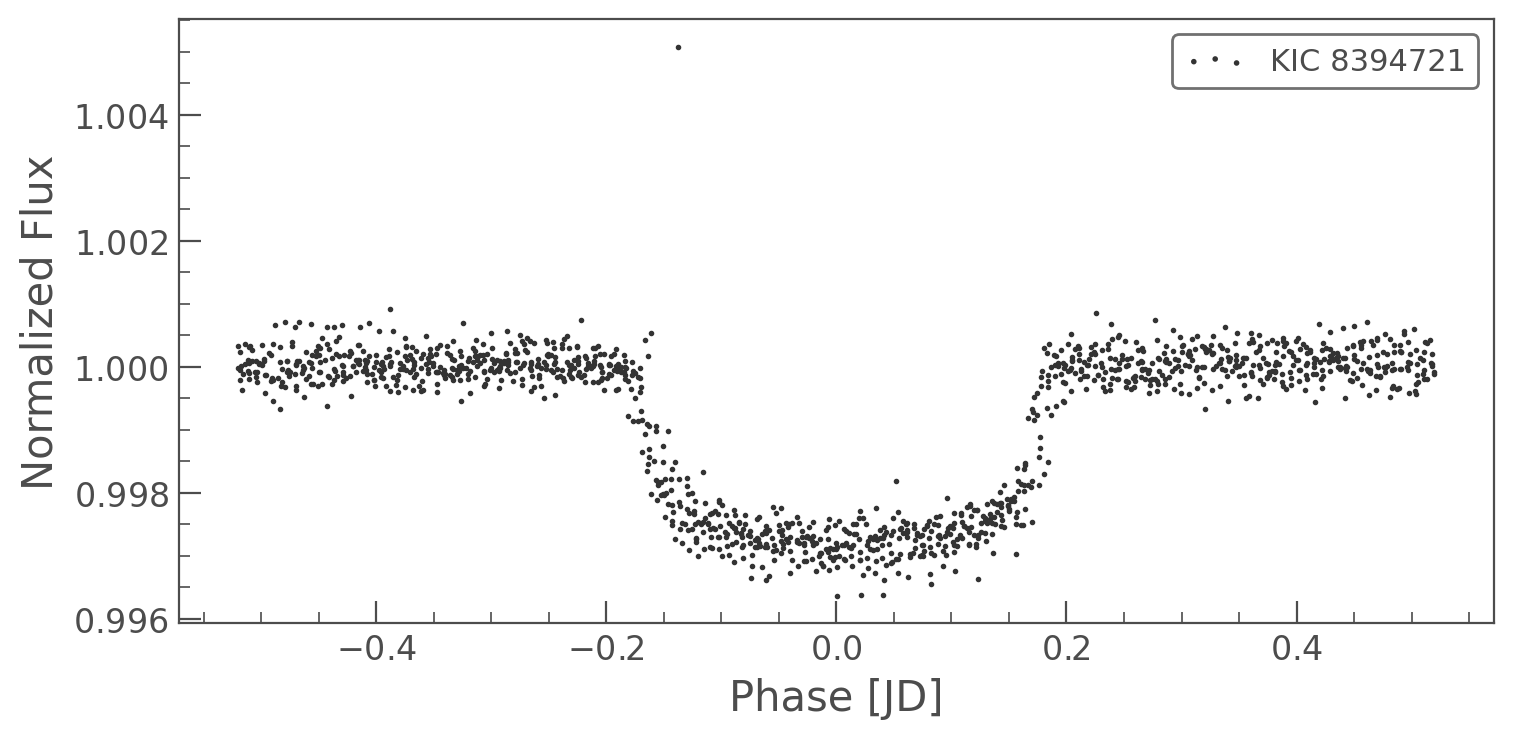

In [63]:
k = np.abs(((clc.time.value - (obs.t0 - 2454833 + obs.period/2))/obs.period) % 1 - 0.5) < 0.01
clc[k].fold(obs.period, obs.t0 - 2454833).scatter()

In [72]:
obs.fit_transit(x_suppl=clc.time.value[k] + 2454833,
                y_suppl=clc.flux.value[k],
                yerr_suppl=clc.flux_err.value[k],
                exptime_suppl=np.median(np.diff(clc.time.value)), fit_t0=True, fit_period=True, fit_inc=True, calc_eclipse=False)

<AxesSubplot:xlabel='Phase', ylabel='$e^-s^{-1}$'>

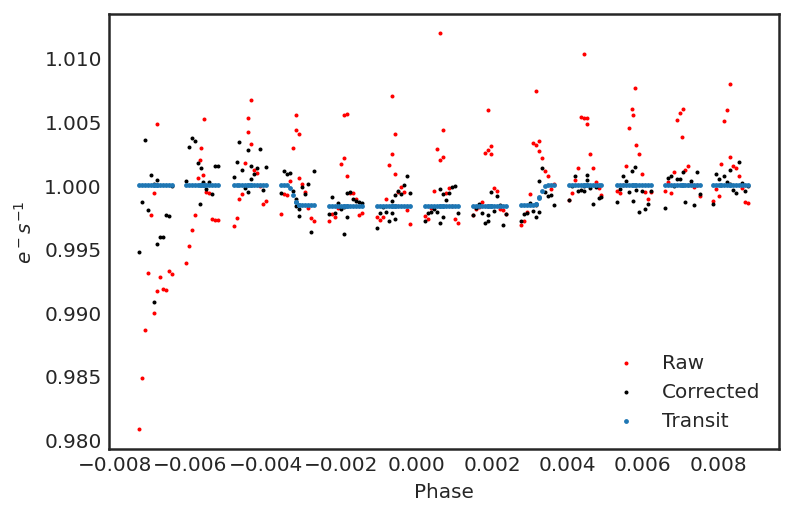

In [73]:
obs.plot()

In [74]:
obs.fit_model()

Fitting Transit/Eclipse Model: 100%|██████████████| 2/2 [00:19<00:00,  9.53s/it]


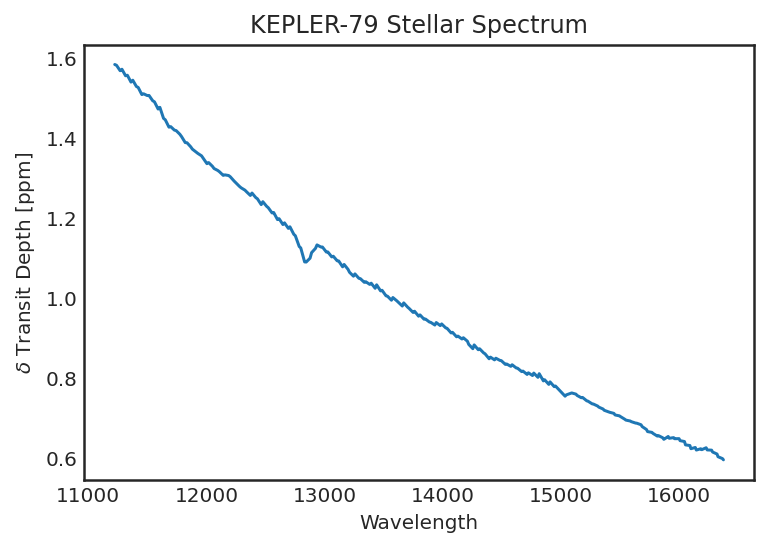

In [75]:
spec = obs.stellar_spectra
spec.plot()
spec.hdulist.writeto(f'results/{name}_stellar_spectrum.fits', overwrite=True)

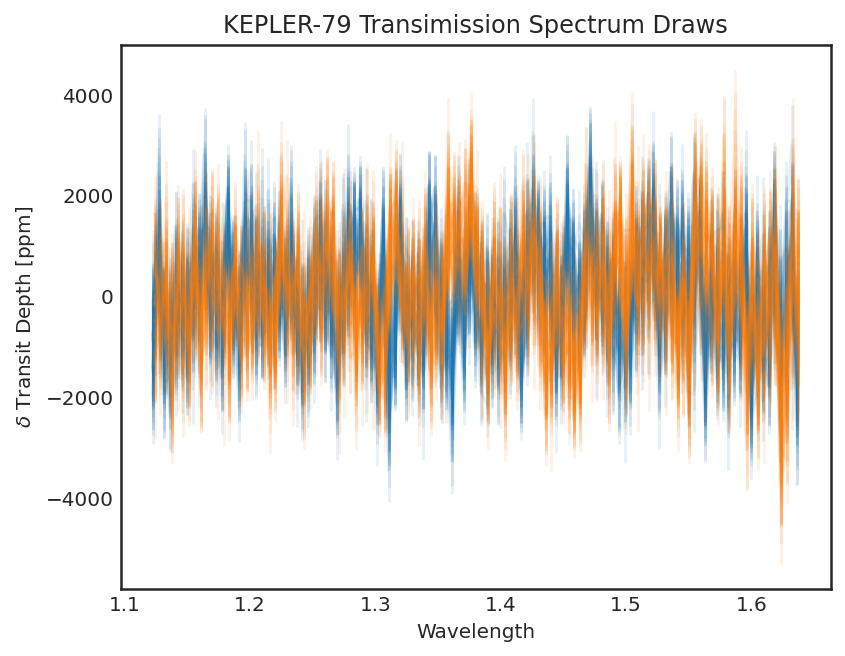

In [76]:
obs.plot_spectra()

[Text(0.5, 1.0, 'Kepler-79 Transmission Spectrum')]

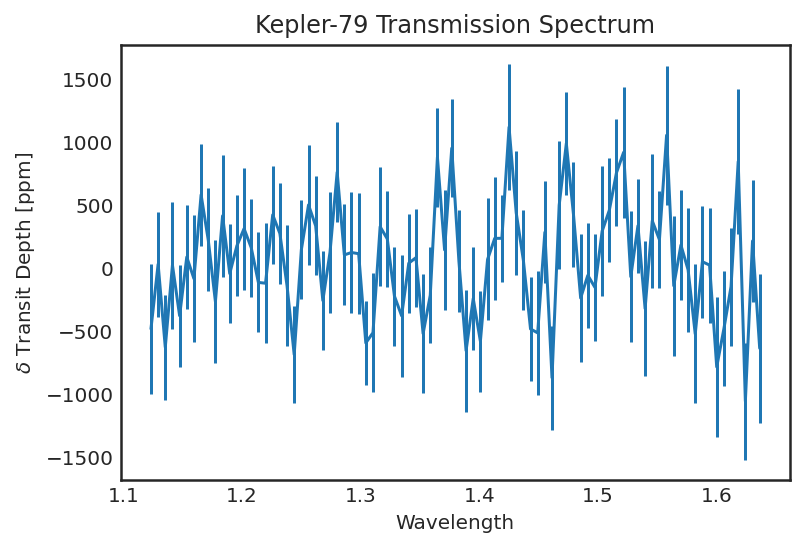

In [80]:
ax = om.Spectra([visit.transmission_spectrum for visit in obs]).flatten().bin(bins=np.linspace(0.8, 1.7, 150)).plot()
ax.set(title=f'{name} Transmission Spectrum')

In [78]:
from astropy.io import fits
try:
    hdulist = om.Spectra([visit.transmission_spectrum for visit in obs if visit.transmission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_transmission.fits')
except:
    pass
try:    
    hdulist = om.Spectra([visit.emission_spectrum for visit in obs if visit.emission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_emission.fits')
except:
    pass

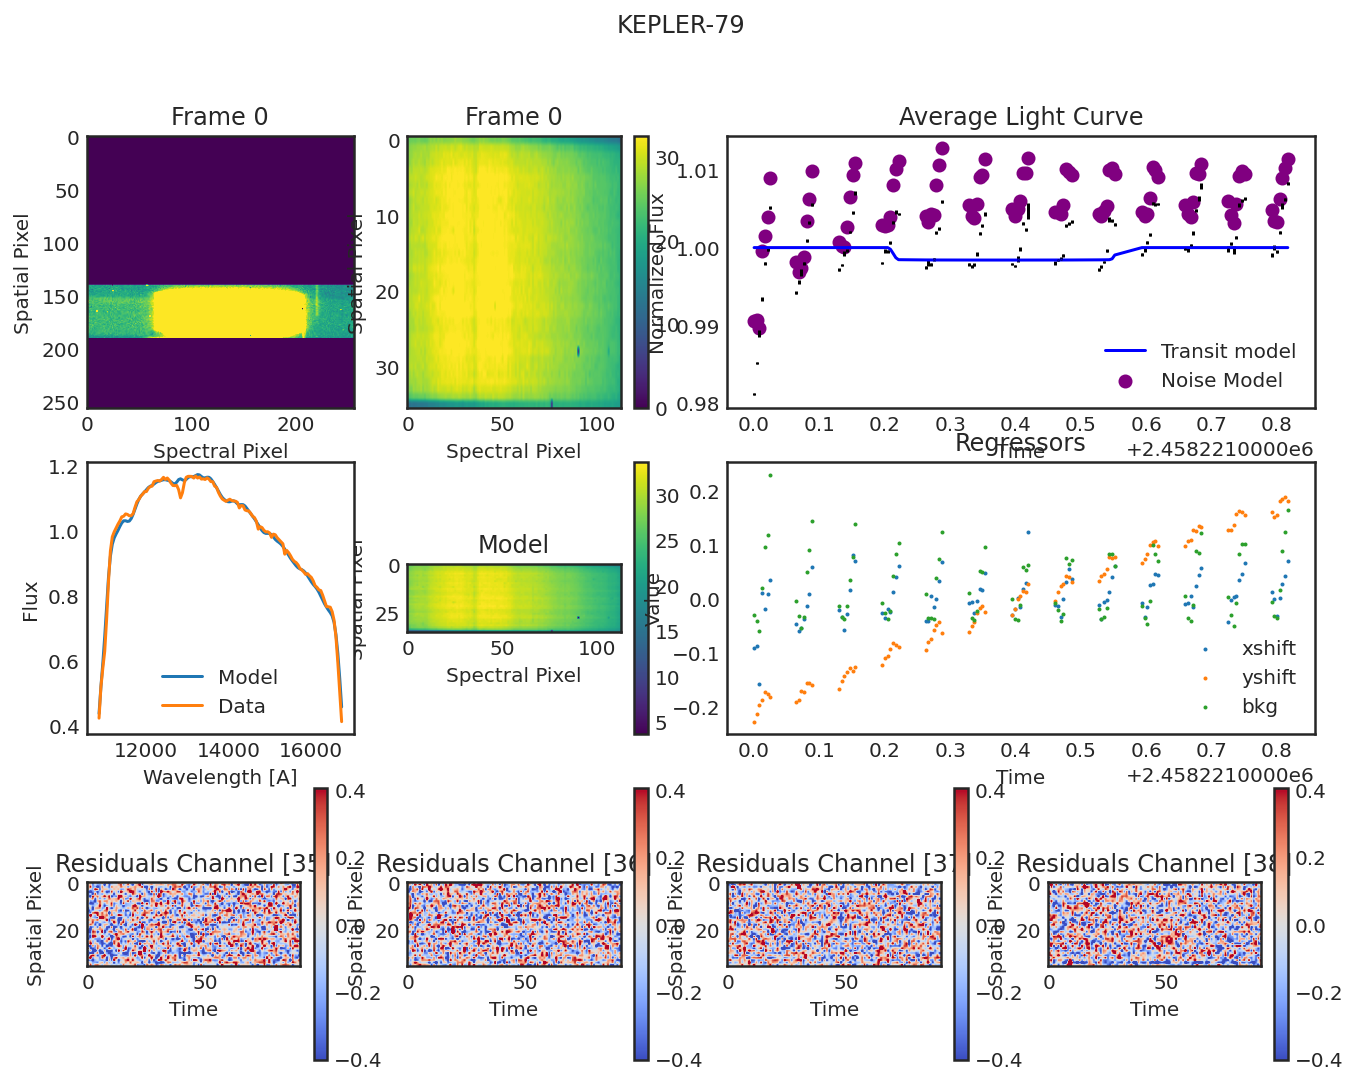

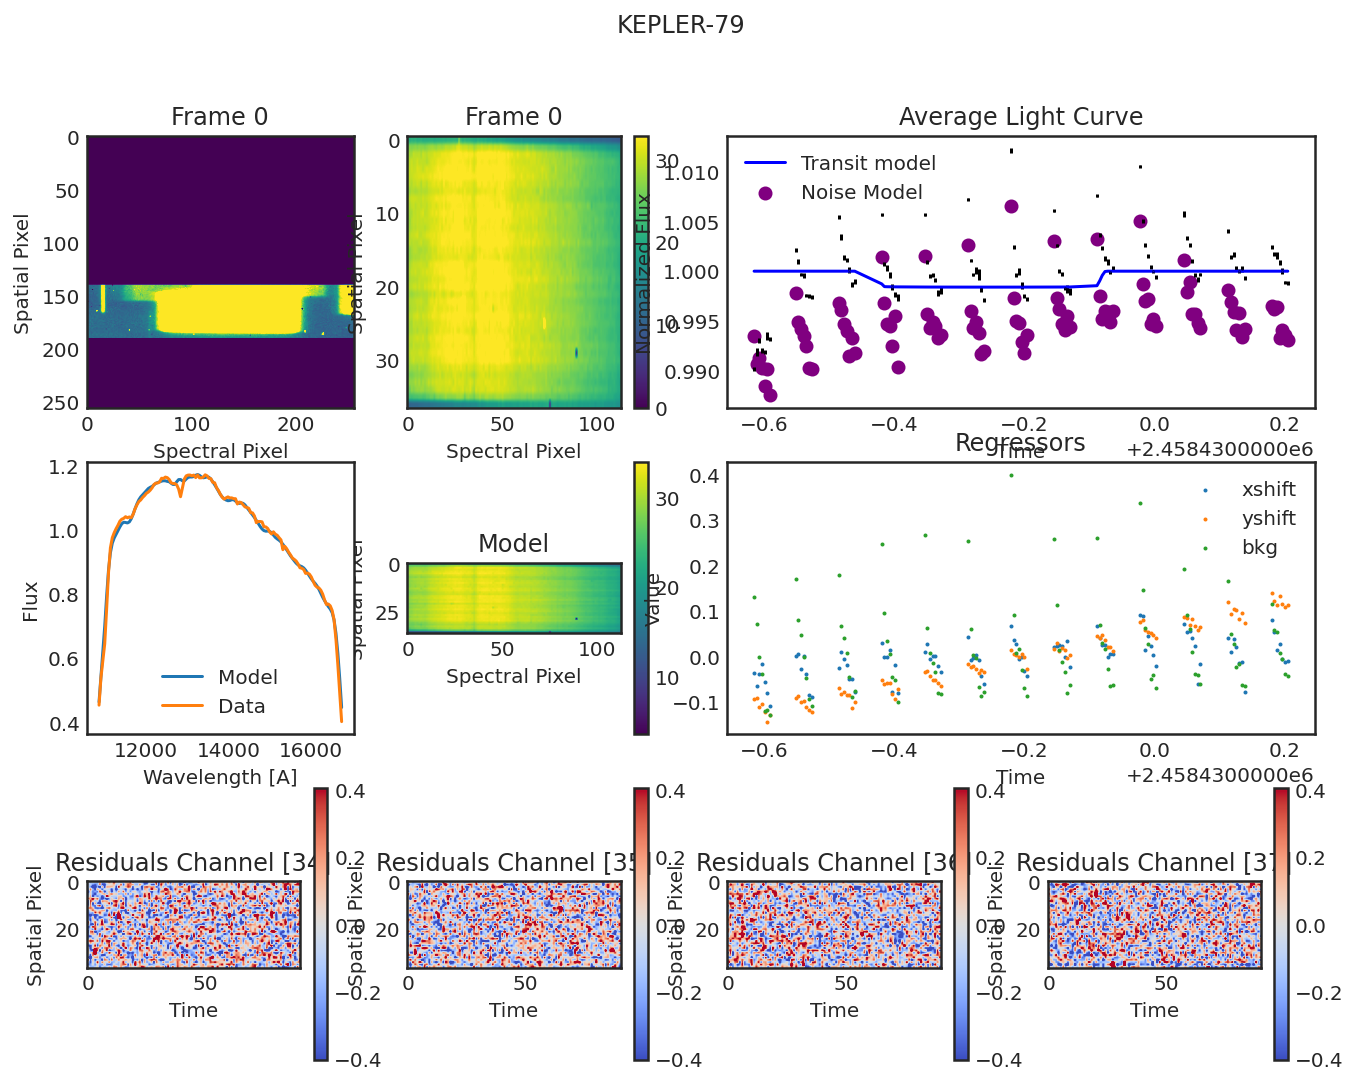

In [79]:
for visit in obs:
    visit.diagnose();
    plt.show();